## The problem statement for this notebook is the same as in the logistic regression notebook, where we need to predict whether it will rain tomorrow or not.

### Data Preprocessing

In [5]:
import opendatasets as od
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# Downloading the dataset
od.download('https://www.kaggle.com/jsphyg/weather-dataset-rattle-package')
raw_df = pd.read_csv('weather-dataset-rattle-package/weatherAUS.csv')
raw_df.dropna(subset=['RainToday', 'RainTomorrow'], inplace=True)

# Creating training, validation and test sets
year = pd.to_datetime(raw_df.Date).dt.year
train_df = raw_df[year < 2015]
val_df = raw_df[year == 2015]
test_df = raw_df[year > 2015]

# Creating inputs and targets
input_cols = list(train_df.columns)[1:-1]
target_col = 'RainTomorrow'
train_inputs, train_targets = train_df[input_cols].copy(), train_df[target_col].copy()
val_inputs, val_targets = val_df[input_cols].copy(), val_df[target_col].copy()
test_inputs, test_targets = test_df[input_cols].copy(), test_df[target_col].copy()

# Identifying numerical and categorical columns
numerical_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes(include='object').columns.tolist()

# Imputing missing numerical values
imputer = SimpleImputer(strategy='mean')
imputer.fit(raw_df[numerical_cols])
train_inputs[numerical_cols] = imputer.transform(train_inputs[numerical_cols])
val_inputs[numerical_cols] = imputer.transform(val_inputs[numerical_cols])
test_inputs[numerical_cols] = imputer.transform(test_inputs[numerical_cols])

# OneHot Encoding of categorical features
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoder.fit(raw_df[categorical_cols])
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
# Step 1: Transforming the categorical columns
encoded_train = pd.DataFrame(encoder.transform(train_inputs[categorical_cols]), columns=encoded_cols, index=train_inputs.index)   # index=train_inputs.index specifies the rows are in the same order as in train_inputs
encoded_val = pd.DataFrame(encoder.transform(val_inputs[categorical_cols]), columns=encoded_cols, index=val_inputs.index)
encoded_test = pd.DataFrame(encoder.transform(test_inputs[categorical_cols]), columns=encoded_cols, index=test_inputs.index)
# Step 2: Concatenating the original DataFrames with the encoded columns
train_inputs = pd.concat([train_inputs, encoded_train], axis=1)
val_inputs = pd.concat([val_inputs, encoded_val], axis=1)
test_inputs = pd.concat([test_inputs, encoded_test], axis=1)

# Saving processed data to disk
train_inputs.to_parquet('train_inputs.parquet')
val_inputs.to_parquet('val_inputs.parquet')
test_inputs.to_parquet('test_inputs.parquet')
pd.DataFrame(train_targets).to_parquet('train_targets.parquet')
pd.DataFrame(val_targets).to_parquet('val_targets.parquet')
pd.DataFrame(test_targets).to_parquet('test_targets.parquet')

# Loading processed data from disk
train_inputs = pd.read_parquet('train_inputs.parquet')
val_inputs = pd.read_parquet('val_inputs.parquet')
test_inputs = pd.read_parquet('test_inputs.parquet')
train_targets = pd.read_parquet('train_targets.parquet')[target_col]
val_targets = pd.read_parquet('val_targets.parquet')[target_col]
test_targets = pd.read_parquet('test_targets.parquet')[target_col]

Skipping, found downloaded files in "./weather-dataset-rattle-package" (use force=True to force download)


In [6]:
# Selecting the columns to be used for training/prediction
X_train = train_inputs[numerical_cols + encoded_cols]
X_val = val_inputs[numerical_cols + encoded_cols]
X_test = test_inputs[numerical_cols + encoded_cols]

### Training and Visualizing Decision Trees

A decision tree in general parlance represents a hierarchical series of binary decisions:

<img src="https://i.imgur.com/qSH4lqz.png" width="480">

A decision tree in machine learning works in exactly the same way, and except that we let the computer figure out the optimal structure & hierarchy of decisions, instead of coming up with criteria manually.

### Training

We can use `DecisionTreeClassifier` from `sklearn.tree` to train a decision tree.

In [7]:
from sklearn.tree import DecisionTreeClassifier

In [8]:
model = DecisionTreeClassifier(random_state=42)

In [9]:
%%time
model.fit(X_train, train_targets)

CPU times: user 3.43 s, sys: 44 ms, total: 3.47 s
Wall time: 3.45 s


DecisionTreeClassifier(random_state=42)

### Evaluation

Let's evaluate the decision tree using the accuracy score.

In [10]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [11]:
train_preds = model.predict(X_train)

In [12]:
train_preds

array(['No', 'No', 'No', ..., 'No', 'No', 'No'], dtype=object)

In [16]:
pd.Series(train_preds).value_counts()

No     76192
Yes    21796
Name: count, dtype: int64

In [17]:
train_probs = model.predict_proba(X_train)

In [18]:
train_probs

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [19]:
accuracy_score(train_targets, train_preds)

0.9999795893374699

The training set accuracy is close to 100%! But we can't rely solely on the training set accuracy, we must evaluate the model on the validation set too. 

We can make predictions and compute accuracy in one step using `model.score`

In [20]:
model.score(X_val, val_targets)

0.7936099245128445

Although the training accuracy is 100%, the accuracy on the validation set is just about 79%, which is only marginally better then always predicting "No". 

It appears that the model has learned the training examples perfect, and doesn't generalize well to previously unseen examples. This phenomenon is called "overfitting", and reducing overfitting is one of the most important parts of any machine learning project.

### Visualization

We can visualize the decision tree _learned_ from the training data.

In [32]:
from sklearn.tree import plot_tree, export_text
import matplotlib.pyplot as plt
import seaborn as sns

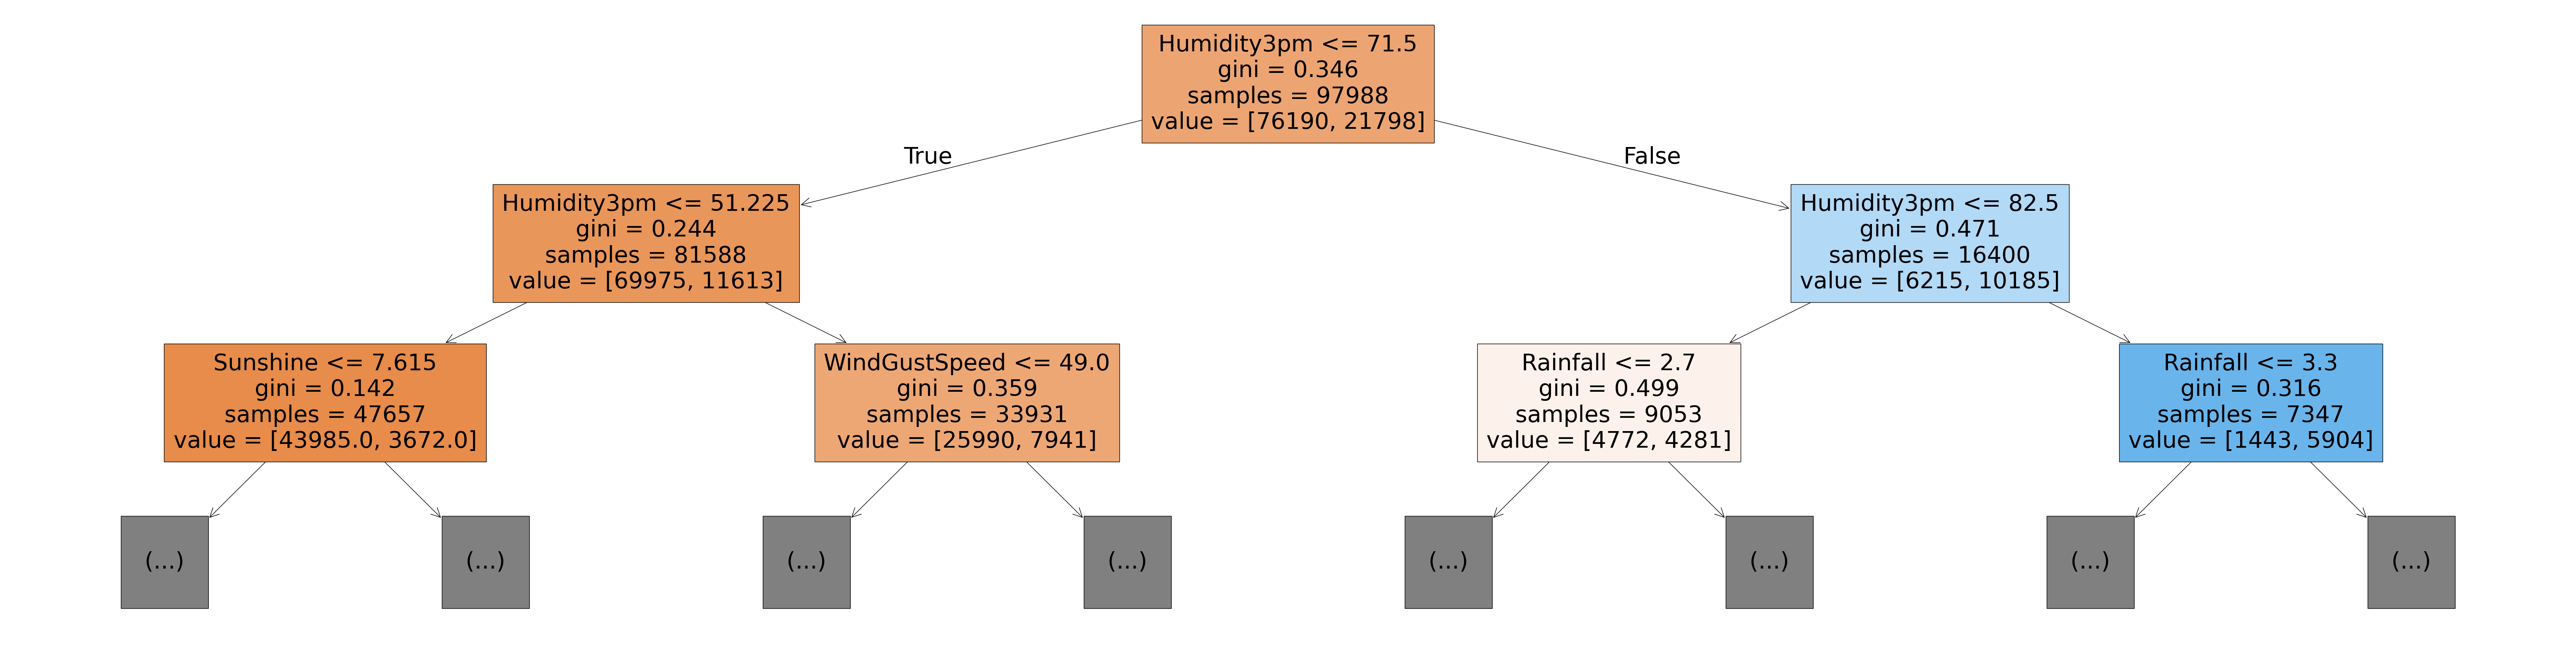

In [26]:
plt.figure(figsize=(80,20))
plot_tree(model, feature_names=X_train.columns, max_depth=2, filled=True);

Can you see how the model classifies a given input as a series of decisions? The tree is truncated here, but following any path from the root node down to a leaf will result in "Yes" or "No". Do you see how a decision tree differs from a logistic regression model?


**How a Decision Tree is Created**

Note the `gini` value in each box. This is the loss function used by the decision tree to decide which column should be used for splitting the data, and at what point the column should be split. A lower Gini index indicates a better split. A perfect split (only one class on each side) has a Gini index of 0. 

For a mathematical discussion of the Gini Index, watch this video: https://www.youtube.com/watch?v=-W0DnxQK1Eo . It has the following formula:

<img src="https://i.imgur.com/CSC0gAo.png" width="240">

Conceptually speaking, while training the models evaluates all possible splits across all possible columns and picks the best one. Then, it recursively performs an optimal split for the two portions. In practice, however, it's very inefficient to check all possible splits, so the model uses a heuristic (predefined strategy) combined with some randomization.

The iterative approach of the machine learning workflow in the case of a decision tree involves growing the tree layer-by-layer:

<img src="https://i.imgur.com/tlYiXnp.png" width="480">


Let's check the depth of the tree that was created.

In [27]:
model.tree_.max_depth

49

We can also display the tree as text, which can be easier to follow for deeper trees.

In [28]:
tree_text = export_text(model, max_depth=10, feature_names=X_train.columns)
print(tree_text[:5000])

|--- Humidity3pm <= 71.50
|   |--- Humidity3pm <= 51.22
|   |   |--- Sunshine <= 7.62
|   |   |   |--- Pressure3pm <= 1013.35
|   |   |   |   |--- Pressure3pm <= 1004.75
|   |   |   |   |   |--- Humidity3pm <= 24.50
|   |   |   |   |   |   |--- WindGustDir_N <= 0.50
|   |   |   |   |   |   |   |--- WindSpeed9am <= 42.00
|   |   |   |   |   |   |   |   |--- Pressure3pm <= 1004.65
|   |   |   |   |   |   |   |   |   |--- WindSpeed3pm <= 5.50
|   |   |   |   |   |   |   |   |   |   |--- class: Yes
|   |   |   |   |   |   |   |   |   |--- WindSpeed3pm >  5.50
|   |   |   |   |   |   |   |   |   |   |--- Temp9am <= 23.75
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 5
|   |   |   |   |   |   |   |   |   |   |--- Temp9am >  23.75
|   |   |   |   |   |   |   |   |   |   |   |--- class: No
|   |   |   |   |   |   |   |   |--- Pressure3pm >  1004.65
|   |   |   |   |   |   |   |   |   |--- class: Yes
|   |   |   |   |   |   |   |--- WindSpeed9am >  42.00
|   |   |  

### Feature Importance

Based on the gini index computations, a decision tree assigns an "importance" value to each feature/column. These values can be used to interpret the results given by a decision tree.

In [29]:
model.feature_importances_

array([3.72348864e-02, 3.02750170e-02, 4.46807871e-02, 2.31016443e-02,
       4.74029876e-02, 6.02158346e-02, 2.59596261e-02, 2.87123098e-02,
       3.72718924e-02, 2.78696714e-01, 3.74751640e-02, 6.22463592e-02,
       1.50293521e-02, 1.72695492e-02, 3.51997396e-02, 3.28171151e-02,
       2.07437921e-03, 1.64079963e-03, 1.01783054e-03, 6.88212657e-04,
       1.48034667e-03, 1.10335980e-03, 1.19280342e-03, 1.77001797e-03,
       8.18956871e-04, 1.30986391e-03, 8.00314193e-04, 2.03677225e-03,
       1.38645663e-03, 4.84888047e-04, 6.08349928e-04, 1.26483304e-03,
       1.45258514e-04, 1.50514431e-03, 1.07182434e-03, 1.44829853e-03,
       9.12938347e-04, 8.15936194e-04, 1.26468932e-03, 1.49092396e-03,
       6.60526489e-04, 7.09652768e-04, 1.02344514e-03, 1.54844869e-03,
       1.31824900e-03, 6.07286685e-04, 5.04774518e-04, 1.50976724e-03,
       1.36782184e-03, 2.12844007e-03, 1.24769141e-03, 1.92047622e-03,
       1.46145581e-03, 2.12670031e-03, 1.36401119e-03, 4.10431985e-04,
      

Let's turn this into a dataframe and visualize the most important features.

In [30]:
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

In [31]:
importance_df.head(10)

,feature,importance
9,Humidity3pm,0.278697
11,Pressure3pm,0.062246
5,WindGustSpeed,0.060216
4,Sunshine,0.047403
2,Rainfall,0.044681
10,Pressure9am,0.037475
8,Humidity9am,0.037272
0,MinTemp,0.037235
14,Temp9am,0.035200
15,Temp3pm,0.032817


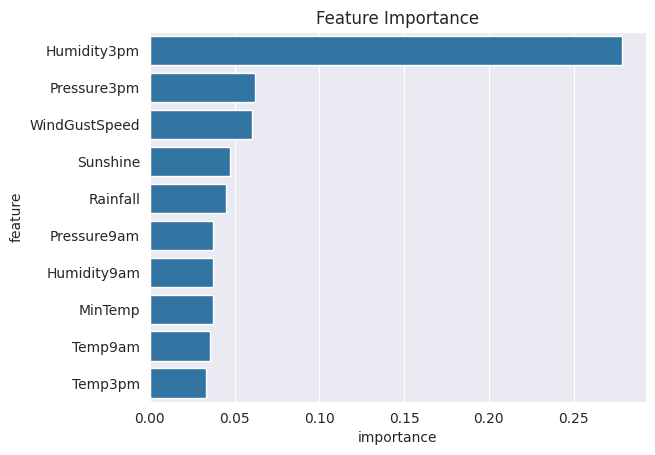

In [38]:
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

## Hyperparameter Tuning and Overfitting

As we saw in the previous section, our decision tree classifier memorized all training examples, leading to a 100% training accuracy, while the validation accuracy was only marginally better than a dumb baseline model. This phenomenon is called overfitting, and in this section, we'll look at some strategies for reducing overfitting. 


The `DecisionTreeClassifier` accepts several arguments, some of which can be modified to reduce overfitting.

These arguments are called hyperparameters because they must be configured manually (as opposed to the parameters within the model which are _learned_ from the data). We'll explore a couple of hyperparameters:

- `max_depth`
- `max_leaf_nodes`

### `max_depth`

By reducing the maximum depth of the decision tree, we can prevent the tree from memorizing all training examples, which may lead to better generalization

In [39]:
model = DecisionTreeClassifier(max_depth=3, random_state=42)

In [40]:
model.fit(X_train, train_targets)

DecisionTreeClassifier(max_depth=3, random_state=42)

We can compute the accuracy of the model on the training and validation sets using `model.score`

In [41]:
model.score(X_train, train_targets)

0.8315916234640977

In [44]:
model.score(X_val, val_targets)

0.8348060155655685

Great, while the training accuracy of the model has gone down, the validation accuracy of the model has increased significantly.

In [45]:
model.classes_

array(['No', 'Yes'], dtype=object)

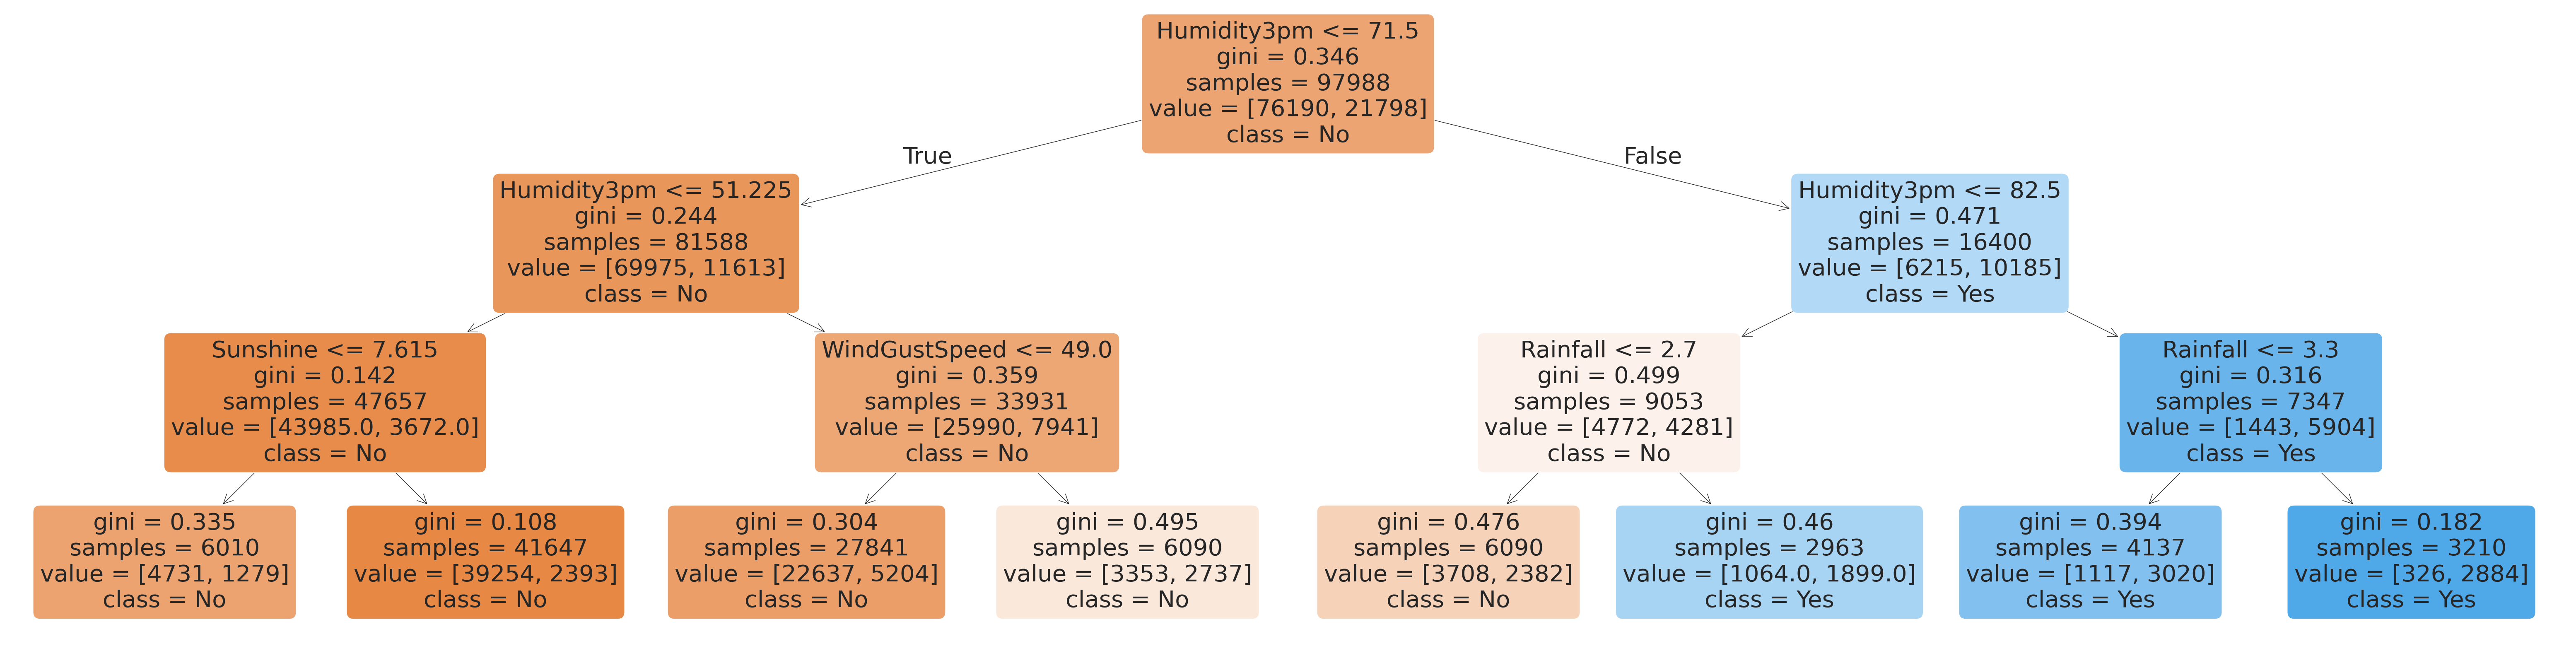

In [46]:
plt.figure(figsize=(80,20))
plot_tree(model, feature_names=X_train.columns, filled=True, rounded=True, class_names=model.classes_);

In [47]:
tree_text = export_text(model, feature_names=X_train.columns)
print(tree_text)

|--- Humidity3pm <= 71.50
|   |--- Humidity3pm <= 51.22
|   |   |--- Sunshine <= 7.62
|   |   |   |--- class: No
|   |   |--- Sunshine >  7.62
|   |   |   |--- class: No
|   |--- Humidity3pm >  51.22
|   |   |--- WindGustSpeed <= 49.00
|   |   |   |--- class: No
|   |   |--- WindGustSpeed >  49.00
|   |   |   |--- class: No
|--- Humidity3pm >  71.50
|   |--- Humidity3pm <= 82.50
|   |   |--- Rainfall <= 2.70
|   |   |   |--- class: No
|   |   |--- Rainfall >  2.70
|   |   |   |--- class: Yes
|   |--- Humidity3pm >  82.50
|   |   |--- Rainfall <= 3.30
|   |   |   |--- class: Yes
|   |   |--- Rainfall >  3.30
|   |   |   |--- class: Yes



Let's experiment with different depths using a helper function.

In [49]:
def max_depth_error(maxDepth):
    model = DecisionTreeClassifier(max_depth=maxDepth, random_state=42)
    model.fit(X_train, train_targets)
    train_error = 1 - model.score(X_train, train_targets)
    val_error = 1 - model.score(X_val, val_targets)
    return {'Max Depth': maxDepth, 'Training Error': train_error, 'Validation Error': val_error}

In [50]:
%%time
errors_df = pd.DataFrame([max_depth_error(maxDepth) for maxDepth in range(1,21)])

CPU times: user 40.9 s, sys: 493 ms, total: 41.4 s
Wall time: 42 s


In [52]:
errors_df

,Max Depth,Training Error,Validation Error
0,1,0.181941,0.176488
1,2,0.176930,0.170695
2,3,0.168408,0.165194
3,4,0.162153,0.161624
4,5,0.157244,0.158113
5,6,0.153131,0.155831
6,7,0.149059,0.154544
7,8,0.144814,0.153842
8,9,0.139435,0.154544
9,10,0.131802,0.154836


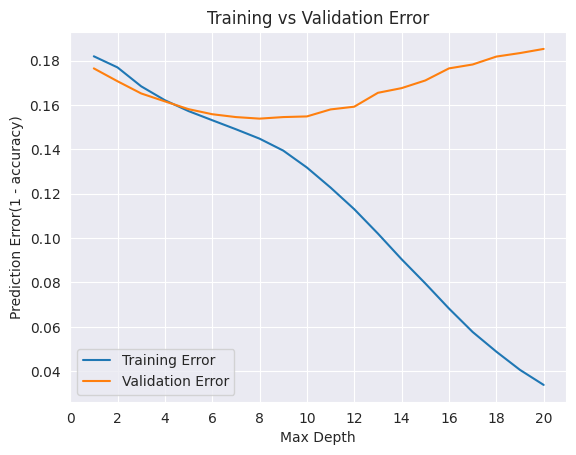

In [53]:
plt.figure()
plt.plot(errors_df['Max Depth'], errors_df['Training Error'])
plt.plot(errors_df['Max Depth'], errors_df['Validation Error'])
plt.title('Training vs Validation Error')
plt.xticks(range(0,21,2))
plt.xlabel('Max Depth')
plt.ylabel('Prediction Error(1 - accuracy)')
plt.legend(['Training Error', 'Validation Error'])
plt.show()

This is a common pattern in all machine learning algorithms:

<img src="https://i.imgur.com/EJCrSZw.png" width="480">




It is often needed to tune hyperparameters carefully to find the optimal fit. In the above case, it appears that a maximum depth of 7 results in the lowest validation error.

In [54]:
model = DecisionTreeClassifier(max_depth=7, random_state=42)
model.fit(X_train, train_targets)
model.score(X_val, val_targets)

0.8454561413774943

### `max_leaf_nodes`

Another way to control the size of complexity of a decision tree is to limit the number of leaf nodes. This allows branches of the tree to have varying depths. 

In [55]:
model = DecisionTreeClassifier(max_leaf_nodes=128, random_state=42)

In [56]:
model.fit(X_train, train_targets)

DecisionTreeClassifier(max_leaf_nodes=128, random_state=42)

In [57]:
model.score(X_train, train_targets)

0.852696248520227

In [58]:
model.score(X_val, val_targets)

0.8471531394464276

In [59]:
model.tree_.max_depth

11

Notice that the model was able to achieve a greater depth of 11 for certain paths while keeping other paths shorter.

In [60]:
tree_text = export_text(model, feature_names=X_train.columns)
print(tree_text[:3000])

|--- Humidity3pm <= 71.50
|   |--- Humidity3pm <= 51.22
|   |   |--- Sunshine <= 7.62
|   |   |   |--- Pressure3pm <= 1013.35
|   |   |   |   |--- Pressure3pm <= 1004.75
|   |   |   |   |   |--- Humidity3pm <= 24.50
|   |   |   |   |   |   |--- class: No
|   |   |   |   |   |--- Humidity3pm >  24.50
|   |   |   |   |   |   |--- Sunshine <= 5.35
|   |   |   |   |   |   |   |--- class: Yes
|   |   |   |   |   |   |--- Sunshine >  5.35
|   |   |   |   |   |   |   |--- class: No
|   |   |   |   |--- Pressure3pm >  1004.75
|   |   |   |   |   |--- Humidity3pm <= 28.50
|   |   |   |   |   |   |--- class: No
|   |   |   |   |   |--- Humidity3pm >  28.50
|   |   |   |   |   |   |--- Cloud3pm <= 3.50
|   |   |   |   |   |   |   |--- class: No
|   |   |   |   |   |   |--- Cloud3pm >  3.50
|   |   |   |   |   |   |   |--- Location_Hobart <= 0.50
|   |   |   |   |   |   |   |   |--- WindGustSpeed <= 36.00
|   |   |   |   |   |   |   |   |   |--- class: No
|   |   |   |   |   |   |   |   |--- WindG